In [137]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [138]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [139]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [140]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [141]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [142]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [143]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement


In [144]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [145]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

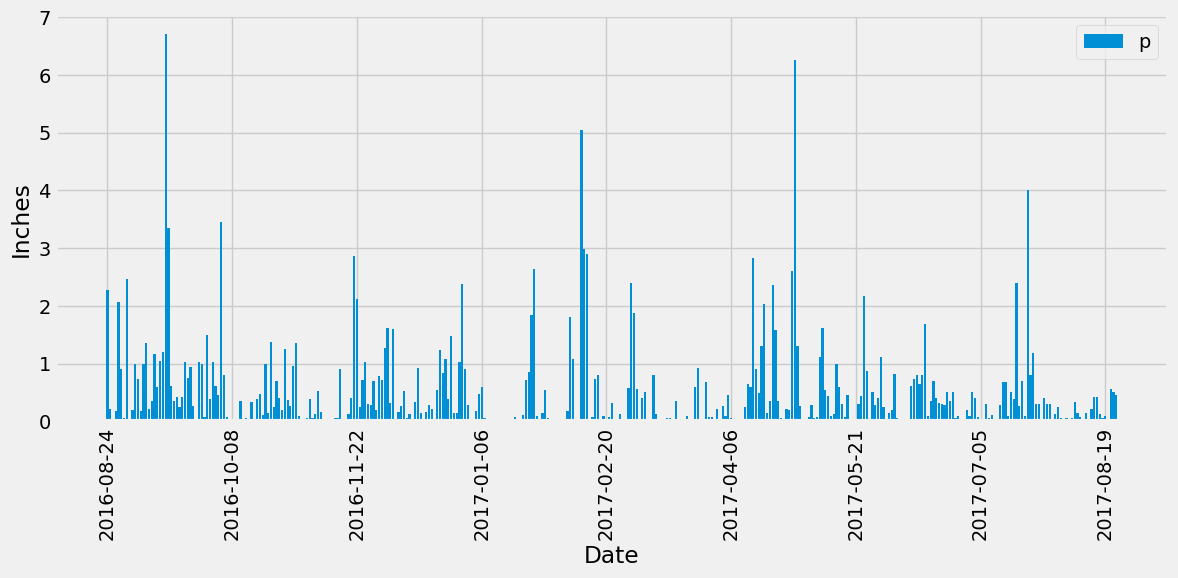

In [146]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year_start = dt.datetime.strptime('2017-08-23', '%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year_start).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_year, columns=['date','prcp'])
df.set_index('date',inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 6))
plt.bar(df.index,df['prcp'])
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend('prcp')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(45)) 
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [147]:
# Use Pandas to calculate the summary statistics for the precipitation data
query = "SELECT prcp FROM measurement"
precipitation_data = pd.read_sql(query, engine)

df = pd.DataFrame(precipitation_data)

summary_statistics = df['prcp'].describe()
summary_statistics

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [148]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).scalar()
total_stations

9

In [149]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [150]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = most_active_stations[0][0]
temperatures = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
               filter(measurement.station == most_active).all()
temperatures[0]

(54.0, 85.0, 71.66378066378067)

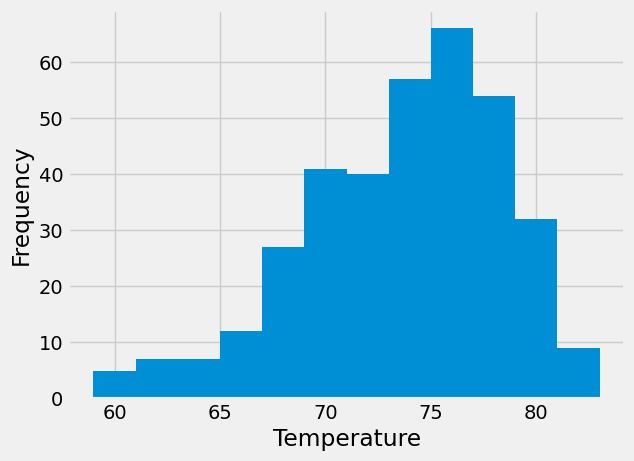

In [151]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = session.query(func.max(measurement.date)).filter(measurement.station == most_active).scalar()
one_year_ago = pd.to_datetime(latest_date, format='%Y-%m-%d') - pd.DateOffset(months=12)

# Query the last 12 months of temperature observation data for the most active station
results = session.query(measurement.tobs).\
          filter(measurement.station == most_active).\
          filter(measurement.date >= one_year_ago.date()).all()

# Load the query results into a Pandas DataFrame
df = pd.DataFrame(results, columns=['Temperature'])

# Plot the results as a histogram
plt.hist(df['Temperature'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [152]:
# Close Session
session.close()